<a href="https://colab.research.google.com/github/LiamJHowarth/IA-Sentinel/blob/main/Canonical_Data_Model_Micro_Py.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Canonical Data Model** - Micro-Py Implementation



## Why a Canonical Data Model is important

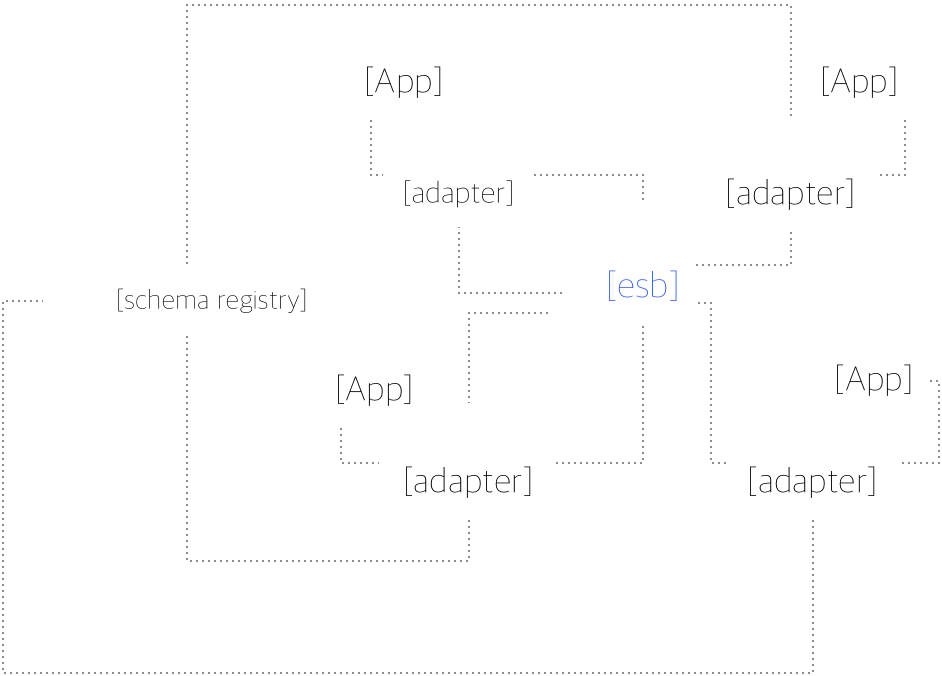

## Decouples systems from each other

Without a CDM, every integration becomes point-to-point (System A ↔ System B, System A ↔ System C, etc.). With N systems you end up with N×(N-1)/2 integrations — an unmaintainable nightmare.
With a CDM, every system only needs to integrate with the canonical model once → only N integrations.

## Reduces translation complexity
Instead of writing 12 different translators for 4 systems talking to each other, you only write 4 translators (one from each system ↔ canonical).

## Provides consistency and a single source of truth
Everyone agrees on what “Customer”, “Order”, “Product” etc. actually mean. This eliminates endless debates and data quality issues caused by semantic differences.

## Future-proofs the architecture
When a new application or an outsourced vendor system is added, you only build one new adapter (vendor format ↔ canonical) instead of modifying every existing integration.

## Simplifies governance, versioning and testing
You can version the canonical model centrally (e.g., v1.0, v1.1, v2.0) and let producers/consumers adopt new versions at their own pace using versioning or content-based routing

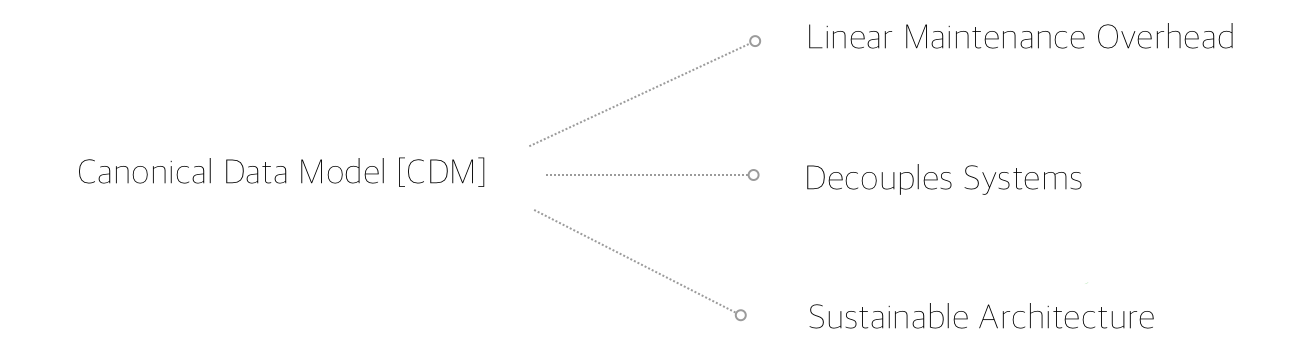



### Scalability Concerns
Solving common data formats in siloed transformation projects becomes unfeasible to implement due to scalability and maintainability of translators. When the scale of applications and/or microservices grow to 6 or more units, given they all send data to each other to fulfill business objectives, we would require 30 or more message translators with out a Canonical Data Model. Therefore is there another way to create a scalable solution for this problem?

Yes. We can use a Canonical Data Model. Adopting the below could reduce dependicies of 30 message translators down to just 12.  





#How does enterprise evolve from P2P integration?

#Let us build a hypothetical case study to investigate.

**What is the scale?**
- ~90 million customers
- 8 000+ microservices and legacy systems
- 150 000+ Kafka messages per second in peak
- 25 000+ REST/gRPC calls per second internally
- 10+ core banking packages (Temenos, Thought Machine, Mambu, Avaloq, Finacle, custom COBOL, etc.)

#### The turning point for enterprise.
The company X was spending upwards of €180–220 million per year just maintaining** point-to-point **integrations. Every new digital product (mobile banking, open banking, instant payments, wealth robo-advisory required 18–36 months and 30–80 custom mappings.

The CIO declared: “We will never again write another direct translation between two internal systems.”

#### What they built – The Enterprise Canonical Model (ECM)

**Foundation**
-  - 80 % BIAN (Banking Industry Architecture Network) service domains and business objects
  - 15 % IFX (Interactive Financial Exchange) for payments and messages
  - 5 % custom NordBank extensions (Nordic-specific regulations, sustainability attributes, etc.)

**Key principles**
1. One single semantic model for the entire group (retail, corporate, investment banking, insurance).
2. The canonical model is the only contract allowed on the internal integration backbone.
3. Every system (new or legacy) gets exactly one adapter/team that is responsible for translating to/from the ECM forever.

**Technology choices**
| Layer                  | Technology chosen                                                                                 | Reason                                                                 |
|-----------------------|----------------------------------------------------------------------------------------------------|-------------------------------------------------------------------------|
| Schema format         | Google Protocol Buffers (Protobuf) primary + JSON Schema fallback                                 | Binary efficiency for Kafka, excellent code generation, versioning    |
| Schema registry       | Confluent Schema Registry (on-prem, multi-datacentre)                                             | Central governance, compatibility rules enforced                       |
| Messaging backbone    | Kafka (300+ clusters, ksqlDB, Kafka Connect)                                                     | Exactly-once, replayability, 10-year retention for audit               |
| Synchronous backbone  | gRPC internally, Kubernetes + Istio service mesh                                                 | Low latency, streaming support, mutual TLS                             |
| API exposure          | Kong/KrakenD API Gateway + GraphQL federation layer for external/partners                         | Public APIs can be a subset or facade of the ECM                       |
| Governance            | Internal “Enterprise Domain Model Board” (chief architects + BIAN experts)                       | Meets every two weeks to approve changes                               |


Every single event and every single gRPC/REST payload that contains customer data uses exactly this structure (or a declared subset/profile).

#### What happens in practice

**Scenario 1 – A new account is opened in the digital banking app (Thought Machine Vault)**
1. Mobile app → REST (public JSON subset) → API Gateway
2. API Gateway translates public JSON → internal ECM Protobuf (Party + CurrentAccount)
3. gRPC call to Account Servicing microservice (creates account, emits AccountOpenedEvent in ECM)
4. AccountOpenedEvent lands on Kafka in ECM format
5. 47 downstream systems (CRM, risk, anti-money-laundering, data lake, core reporting, etc.) consume the exact same event without any further translation.

**Scenario 2 – SEPA Instant Payment comes in via SWIFT or TIPS**
1. Legacy mainframe receives MT or ISO 20022 → adapter translates to ECM PaymentInitiatedEvent
2. Event goes to Kafka → Payments Engine (Java/Kotlin) processes it using the exact same ECM objects
3. Payments Engine calls Fraud service via gRPC (again ECM objects)
4. Once executed → PaymentExecutedEvent in ECM format is published → 30+ subscribers instantly updated.

#### Results after four years (2024 numbers)
| Metric                                    | Before ECM (2018)          | With ECM (2024)               | Improvement      |
|-------------------------------------------|----------------------------|-------------------------------|------------------|
| Cost of integration per year              | €180–220 m                 | €42 m                         | –78 %            |
| Time to onboard a new vendor/system       | 12–24 months               | 6–10 weeks                    | –90 %             |
| Number of active data formats internally | >180                       | 1 (ECM) + a few legacy edges  |                  |
| Re-usability of business events           | <10 %                      | 96 %                          |                  |
| Failed open-banking PSD2 queries due to mapping bugs | ~8 %                | 0.04 %                        |                  |

#### Lessons they openly share in BIAN working groups
1. Start with BIAN/IFX — do not invent your own objects unless absolutely required by local law.
2. Enforce the canonical model with schema-registry compatibility rules set to FULL (no breaking changes allowed without version bump).
3. Make the adapter teams permanently responsible — they own the contract forever (incentivises them to keep it stable).
4. Use the exact same Protobuf/JSON Schema files for both Kafka Avro and gRPC code generation (single source of truth).
5. Allow “profiles” or “views” (e.g., PublicCustomerProfile, RegulatoryReportingProfile) instead of forking the model.

This is now the gold standard that many other European banks (ING, BNP Paribas, Santander, Crédit Agricole, etc.) are copying or have already copied.

If you are in banking or insurance and you want to kill integration hell forever, this is the proven playbook.

## Canonical Data Model with Python

A Canonical Data Model (CDM) is a design pattern used to reduce the complexity of integrating multiple applications. Instead of having each application know how to communicate with every other application's specific data format, all applications translate their data to and from a single, standardized "canonical" format.

Let's imagine we have three hypothetical applications, each with a different way of representing 'User' data. Our goal is to convert all these different formats into a single, unified canonical representation.

### 1. Hypothetical Application Data Formats

Here are three different ways our applications might represent user information:

In [ ]:
import json

# Application 1: CRM System (JSON-like dictionary)
crm_user_data = {
    "customer_id": "C001",
    "first_name": "Alice",
    "last_name": "Smith",
    "email_address": "alice.smith@example.com",
    "status": "active",
    "registration_date": "2023-01-15"
}

# Application 2: E-commerce Platform (Tuple-based)
ecommerce_user_data = (
    "alice_s",
    "Alice Smith",
    "alice.smith@example.com",
    True, # Is active
    "2023-01-15 10:30:00"
)

# Application 3: HR System (List of dictionaries with different keys)
hr_user_data = [
    {"employee_id": "EMP001", "full_name": "Alice Smith", "contact_email": "alice.smith@example.com", "is_active": "Y", "created_at": "1673779200"}, # Unix timestamp
    {"employee_id": "EMP002", "full_name": "Bob Johnson", "contact_email": "bob.j@example.com", "is_active": "N", "created_at": "1673779200"}
]

print("CRM Data:", json.dumps(crm_user_data, indent=2))
print("\nE-commerce Data:", ecommerce_user_data)
print("\nHR Data:", json.dumps(hr_user_data, indent=2))

CRM Data: {
  "customer_id": "C001",
  "first_name": "Alice",
  "last_name": "Smith",
  "email_address": "alice.smith@example.com",
  "status": "active",
  "registration_date": "2023-01-15"
}

E-commerce Data: ('alice_s', 'Alice Smith', 'alice.smith@example.com', True, '2023-01-15 10:30:00')

HR Data: [
  {
    "employee_id": "EMP001",
    "full_name": "Alice Smith",
    "contact_email": "alice.smith@example.com",
    "is_active": "Y",
    "created_at": "1673779200"
  },
  {
    "employee_id": "EMP002",
    "full_name": "Bob Johnson",
    "contact_email": "bob.j@example.com",
    "is_active": "N",
    "created_at": "1673779200"
  }
]


### 2. Define the Canonical Data Model

We'll define a standardised dictionary format that can accommodate all necessary information from our different sources. This model aims to be comprehensive but also normalized to avoid redundancy and inconsistencies.

In [ ]:
from datetime import datetime

def canonical_data_model(RIM, full_name)

def create_canonical_user(user_id, full_name, email, is_active, created_at):
    """
    Liam: Create a standardised user dictionary based on the Canonical Data Model.
    """
    return {
        "user_id": str(user_id), # Ensure ID is always a string
        "full_name": str(full_name),
        "email": str(email),
        "is_active": bool(is_active), # Standardize to boolean
        "created_at": created_at.isoformat() if isinstance(created_at, datetime) else str(created_at) # Standardize date format
    }

# Example of an empty canonical user (for reference)
canonical_user_template = {
    "user_id": None,
    "full_name": None,
    "email": None,
    "is_active": None,
    "created_at": None # ISO 8601 format preferred
}

print("Canonical User Template:", json.dumps(canonical_user_template, indent=2))

Canonical User Template: {
  "user_id": null,
  "full_name": null,
  "email": null,
  "is_active": null,
  "created_at": null
}


### 3. Implement Converters to the Canonical Model

Now, we'll write functions to convert data from each application's format into our `create_canonical_user` function's expected arguments.

In [ ]:
def convert_crm_to_canonical(crm_data):
    return create_canonical_user(
        user_id=crm_data["customer_id"],
        full_name=f"{crm_data['first_name']} {crm_data['last_name']}",
        email=crm_data["email_address"],
        is_active=(crm_data["status"] == "active"),
        created_at=datetime.fromisoformat(crm_data["registration_date"])
    )

def convert_ecommerce_to_canonical(ecommerce_data):
    username, full_name, email, is_active, created_at_str = ecommerce_data
    return create_canonical_user(
        user_id=username, # Using username as ID for this app
        full_name=full_name,
        email=email,
        is_active=is_active,
        created_at=datetime.strptime(created_at_str, "%Y-%m-%d %H:%M:%S")
    )

def convert_hr_to_canonical(hr_data_entry):
    # hr_data_entry is one dictionary from the list
    return create_canonical_user(
        user_id=hr_data_entry["employee_id"],
        full_name=hr_data_entry["full_name"],
        email=hr_data_entry["contact_email"],
        is_active=(hr_data_entry["is_active"] == "Y"),
        created_at=datetime.fromtimestamp(int(hr_data_entry["created_at"]))
    )

### 4. Demonstrate Conversions

Now let's see our data transformed into the canonical format.

In [ ]:
# Convert CRM data
canonical_crm_user = convert_crm_to_canonical(crm_user_data)
print("Canonical CRM User:", json.dumps(canonical_crm_user, indent=2))

# Convert E-commerce data
canonical_ecommerce_user = convert_ecommerce_to_canonical(ecommerce_user_data)
print("\nCanonical E-commerce User:", json.dumps(canonical_ecommerce_user, indent=2))

# Convert HR data (each entry separately)
canonical_hr_users = [convert_hr_to_canonical(entry) for entry in hr_user_data]
print("\nCanonical HR Users:", json.dumps(canonical_hr_users, indent=2))

Canonical CRM User: {
  "user_id": "C001",
  "full_name": "Alice Smith",
  "email": "alice.smith@example.com",
  "is_active": true,
  "created_at": "2023-01-15T00:00:00"
}

Canonical E-commerce User: {
  "user_id": "alice_s",
  "full_name": "Alice Smith",
  "email": "alice.smith@example.com",
  "is_active": true,
  "created_at": "2023-01-15T10:30:00"
}

Canonical HR Users: [
  {
    "user_id": "EMP001",
    "full_name": "Alice Smith",
    "email": "alice.smith@example.com",
    "is_active": true,
    "created_at": "2023-01-15T10:40:00"
  },
  {
    "user_id": "EMP002",
    "full_name": "Bob Johnson",
    "email": "bob.j@example.com",
    "is_active": false,
    "created_at": "2023-01-15T10:40:00"
  }
]


### When to use?
This model is also known as a double translation, therefore use it only in the context of the requirement. For example, if latency and throughput is critical, then a double translation may not be efficient enough. But for most cases, the benefits of using such a model can transform the way cross-functional terms work together and refer to data within the specified domain. For enteprise that commonly have a large noumber of disparate applications, a canonical data model can reduce ambiguity and dissonance between systems.

### Conclusion

As you can see, all three different input formats are now consistently represented in our `canonical_user` dictionary structure. This allows any consuming application to only understand one data format, significantly simplifying integration efforts and improving maintainability.